**Chapter 17 – Autoencoders and GANs**

_This notebook contains all the sample code in chapter 17._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import numpy as np

import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


A couple utility functions to plot grayscale 28x28 image:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

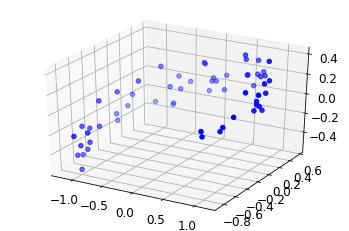

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0],X_train[:,1],X_train[:,2], c='b',marker='o')
plt.show()


Now let's build the Autoencoder...

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 0s 6ms/sample - loss: 0.3064
Epoch 2/20
60/60 [==============================] - 0s 99us/sample - loss: 0.3797
Epoch 3/20
60/60 [==============================] - 0s 83us/sample - loss: 0.1454
Epoch 4/20
60/60 [==============================] - 0s 116us/sample - loss: 0.0872
Epoch 5/20
60/60 [==============================] - 0s 100us/sample - loss: 0.0658
Epoch 6/20
60/60 [==============================] - 0s 83us/sample - loss: 0.0464
Epoch 7/20
60/60 [==============================] - 0s 83us/sample - loss: 0.0356
Epoch 8/20
60/60 [==============================] - 0s 83us/sample - loss: 0.0238
Epoch 9/20
60/60 [==============================] - 0s 83us/sample - loss: 0.0225
Epoch 10/20
60/60 [==============================] - 0s 66us/sample - loss: 0.0093
Epoch 11/20
60/60 [==============================] - 0s 83us/sample - loss: 0.0068
Epoch 12/20
60/60 [==============================] - 0s 100us/sample - loss

In [7]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


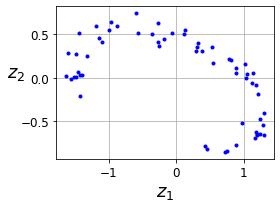

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 5s 87us/sample - loss: 0.1844 - rounded_accuracy: 0.9184 - val_loss: 0.1423 - val_rounded_accuracy: 0.9417
Epoch 2/20
55000/55000 [==============================] - 4s 82us/sample - loss: 0.1322 - rounded_accuracy: 0.9477 - val_loss: 0.1264 - val_rounded_accuracy: 0.9514
Epoch 3/20
55000/55000 [==============================] - 5s 83us/sample - loss: 0.1231 - rounded_accuracy: 0.9527 - val_loss: 0.1208 - val_rounded_accuracy: 0.9544
Epoch 4/20
55000/55000 [==============================] - 5s 83us/sample - loss: 0.1180 - rounded_accuracy: 0.9556 - val_loss: 0.1169 - val_rounded_accuracy: 0.9566
Epoch 5/20
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1149 - rounded_accuracy: 0.9572 - val_loss: 0.1147 - val_rounded_accuracy: 0.9570
Epoch 6/20
55000/55000 [==============================] - 5s 83us/sample - loss: 0.1125 - rounded_accuracy: 0.9586 - val_loss:

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


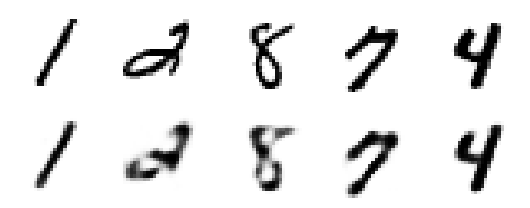

In [13]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

# Visualizing MNIST Images

In [14]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

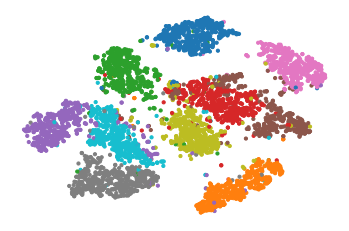

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


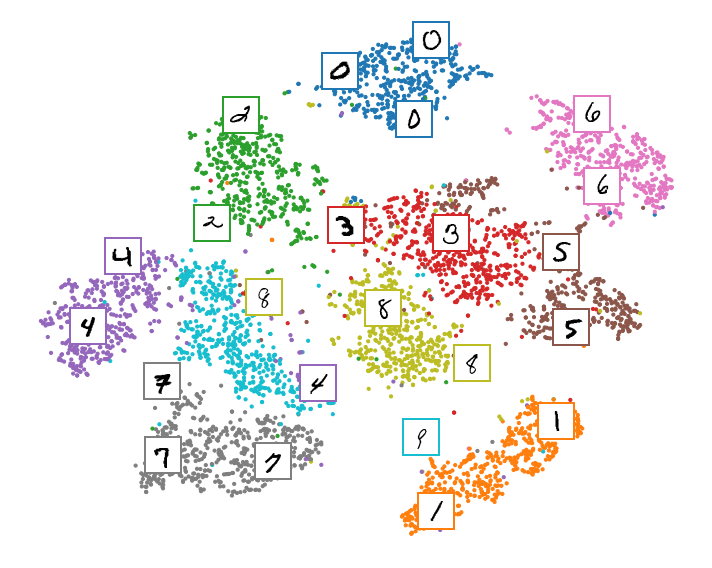

In [16]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [17]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.1527 - rounded_accuracy: 0.9364 - val_loss: 0.1170 - val_rounded_accuracy: 0.9572
Epoch 2/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.1108 - rounded_accuracy: 0.9601 - val_loss: 0.1069 - val_rounded_accuracy: 0.9621
Epoch 3/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.1037 - rounded_accuracy: 0.9641 - val_loss: 0.1010 - val_rounded_accuracy: 0.9662
Epoch 4/10
55000/55000 [==============================] - 4s 82us/sample - loss: 0.1004 - rounded_accuracy: 0.9660 - val_loss: 0.1003 - val_rounded_accuracy: 0.9667
Epoch 5/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.0985 - rounded_accuracy: 0.9670 - val_loss: 0.0980 - val_rounded_accuracy: 0.9677
Epoch 6/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.0974 - rounded_accuracy: 0.9676 - val_loss:

Saving figure tied_ae


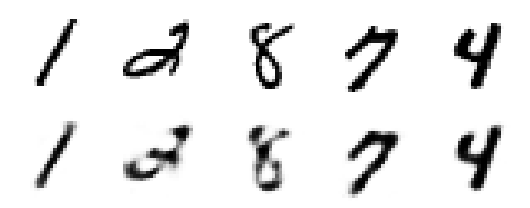

In [19]:
show_reconstructions(tied_ae)
save_fig("tied_ae")
plt.show()

## Training one Autoencoder at a Time

In [20]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=[X_valid, X_valid])
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.1866 - rounded_accuracy: 0.9228 - val_loss: 0.1346 - val_rounded_accuracy: 0.9500
Epoch 2/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.1197 - rounded_accuracy: 0.9575 - val_loss: 0.1092 - val_rounded_accuracy: 0.9633
Epoch 3/10
55000/55000 [==============================] - 4s 71us/sample - loss: 0.1031 - rounded_accuracy: 0.9663 - val_loss: 0.0986 - val_rounded_accuracy: 0.9691
Epoch 4/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.0951 - rounded_accuracy: 0.9707 - val_loss: 0.0929 - val_rounded_accuracy: 0.9724
Epoch 5/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.0903 - rounded_accuracy: 0.9735 - val_loss: 0.0891 - val_rounded_accuracy: 0.9744
Epoch 6/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.0871 - rounded_accuracy: 0.9754 - val_loss:

In [22]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

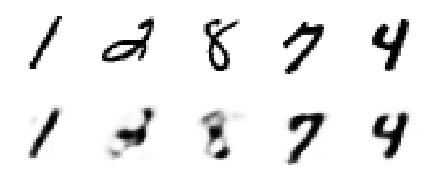

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 90us/sample - loss: 0.1259 - rounded_accuracy: 0.9510 - val_loss: 0.1226 - val_rounded_accuracy: 0.9527
Epoch 2/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1211 - rounded_accuracy: 0.9536 - val_loss: 0.1201 - val_rounded_accuracy: 0.9544
Epoch 3/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.1193 - rounded_accuracy: 0.9547 - val_loss: 0.1191 - val_rounded_accuracy: 0.9551
Epoch 4/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.1181 - rounded_accuracy: 0.9555 - val_loss: 0.1179 - val_rounded_accuracy: 0.9559
Epoch 5/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.1171 - rounded_accuracy: 0.9561 - val_loss: 0.1169 - val_rounded_accuracy: 0.9565
Epoch 6/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.1162 - rounded_accuracy: 0.9567 - val_loss:

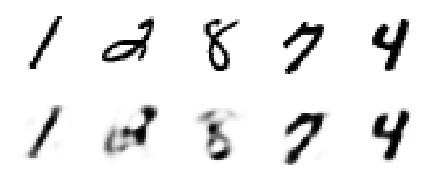

In [25]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 8s 149us/sample - loss: 0.1105 - rounded_accuracy: 0.9614 - val_loss: 0.0853 - val_rounded_accuracy: 0.9756
Epoch 2/5
55000/55000 [==============================] - 7s 121us/sample - loss: 0.0815 - rounded_accuracy: 0.9777 - val_loss: 0.0794 - val_rounded_accuracy: 0.9794
Epoch 3/5
55000/55000 [==============================] - 7s 120us/sample - loss: 0.0772 - rounded_accuracy: 0.9807 - val_loss: 0.0760 - val_rounded_accuracy: 0.9817
Epoch 4/5
55000/55000 [==============================] - 7s 124us/sample - loss: 0.0749 - rounded_accuracy: 0.9822 - val_loss: 0.0770 - val_rounded_accuracy: 0.9807
Epoch 5/5
55000/55000 [==============================] - 7s 126us/sample - loss: 0.0735 - rounded_accuracy: 0.9833 - val_loss: 0.0734 - val_rounded_accuracy: 0.9838


In [27]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

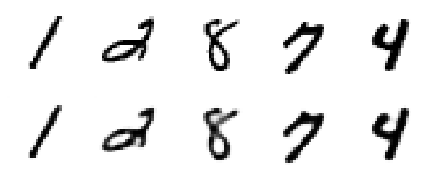

In [28]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders

In [29]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [30]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 17s 318us/sample - loss: 0.3478 - rounded_accuracy: 0.8655 - val_loss: 0.3128 - val_rounded_accuracy: 0.8684
Epoch 2/10
55000/55000 [==============================] - 15s 267us/sample - loss: 0.3034 - rounded_accuracy: 0.8677 - val_loss: 0.2970 - val_rounded_accuracy: 0.8684
Epoch 3/10
55000/55000 [==============================] - 14s 263us/sample - loss: 0.2886 - rounded_accuracy: 0.8674 - val_loss: 0.2800 - val_rounded_accuracy: 0.8673
Epoch 4/10
55000/55000 [==============================] - 15s 269us/sample - loss: 0.2738 - rounded_accuracy: 0.8671 - val_loss: 0.2643 - val_rounded_accuracy: 0.8665
Epoch 5/10
55000/55000 [==============================] - 15s 267us/sample - loss: 0.2588 - rounded_accuracy: 0.8672 - val_loss: 0.2578 - val_rounded_accuracy: 0.8664
Epoch 6/10
55000/55000 [==============================] - 15s 269us/sample - loss: 0.2525 - rounded_accuracy: 0.8686

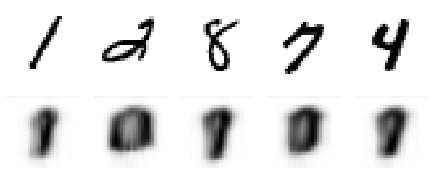

In [31]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

Using Gaussian noise:

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.2046 - rounded_accuracy: 0.9070 - val_loss: 0.1568 - val_rounded_accuracy: 0.9340
Epoch 2/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.1464 - rounded_accuracy: 0.9397 - val_loss: 0.1335 - val_rounded_accuracy: 0.9474
Epoch 3/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1339 - rounded_accuracy: 0.9466 - val_loss: 0.1276 - val_rounded_accuracy: 0.9506
Epoch 4/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1295 - rounded_accuracy: 0.9489 - val_loss: 0.1240 - val_rounded_accuracy: 0.9524
Epoch 5/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1265 - rounded_accuracy: 0.9505 - val_loss: 0.1212 - val_rounded_accuracy: 0.9538
Epoch 6/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1244 - rounded_accuracy: 0.9516 - val_loss:

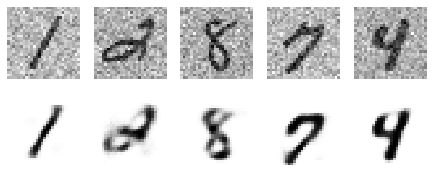

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.2118 - rounded_accuracy: 0.9025 - val_loss: 0.1615 - val_rounded_accuracy: 0.9314
Epoch 2/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1599 - rounded_accuracy: 0.9313 - val_loss: 0.1396 - val_rounded_accuracy: 0.9444
Epoch 3/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1487 - rounded_accuracy: 0.9375 - val_loss: 0.1336 - val_rounded_accuracy: 0.9478
Epoch 4/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1429 - rounded_accuracy: 0.9406 - val_loss: 0.1283 - val_rounded_accuracy: 0.9499
Epoch 5/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.1388 - rounded_accuracy: 0.9429 - val_loss: 0.1250 - val_rounded_accuracy: 0.9519
Epoch 6/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.1360 - rounded_accuracy: 0.9444 - val_loss:

Saving figure dropout_denoising_plot


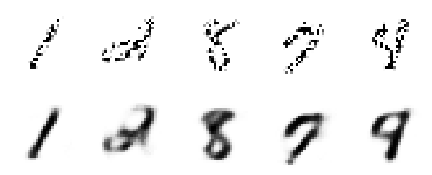

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [36]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.2662 - rounded_accuracy: 0.8680 - val_loss: 0.2447 - val_rounded_accuracy: 0.8763
Epoch 2/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.2281 - rounded_accuracy: 0.8879 - val_loss: 0.2103 - val_rounded_accuracy: 0.9012
Epoch 3/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.1984 - rounded_accuracy: 0.9078 - val_loss: 0.1876 - val_rounded_accuracy: 0.9148
Epoch 4/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.1814 - rounded_accuracy: 0.9185 - val_loss: 0.1747 - val_rounded_accuracy: 0.9231
Epoch 5/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.1705 - rounded_accuracy: 0.9255 - val_loss: 0.1660 - val_rounded_accuracy: 0.9286
Epoch 6/10
55000/55000 [==============================] - 5s 82us/sample - loss: 0.1615 - rounded_accuracy: 0.9312 - val_loss:

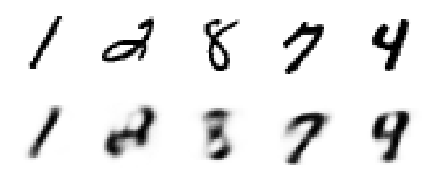

In [37]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [38]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [39]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

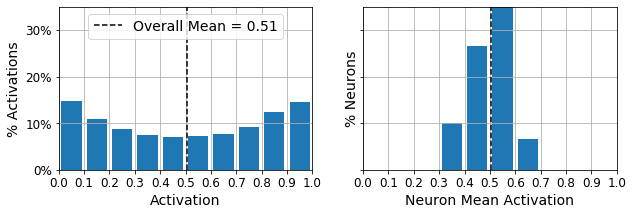

In [40]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Now let's add $\ell_1$ regularization to the coding layer:

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 95us/sample - loss: 0.2823 - rounded_accuracy: 0.8689 - val_loss: 0.2547 - val_rounded_accuracy: 0.8744
Epoch 2/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.2482 - rounded_accuracy: 0.8771 - val_loss: 0.2436 - val_rounded_accuracy: 0.8804
Epoch 3/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.2380 - rounded_accuracy: 0.8839 - val_loss: 0.2328 - val_rounded_accuracy: 0.8864
Epoch 4/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.2285 - rounded_accuracy: 0.8892 - val_loss: 0.2251 - val_rounded_accuracy: 0.8907
Epoch 5/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.2212 - rounded_accuracy: 0.8940 - val_loss: 0.2156 - val_rounded_accuracy: 0.8985
Epoch 6/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.2086 - rounded_accuracy: 0.9039 - val_loss:

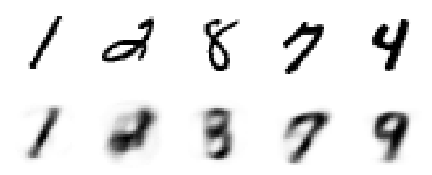

In [42]:
show_reconstructions(sparse_l1_ae)

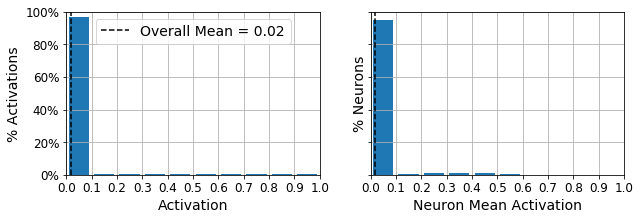

In [43]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Saving figure sparsity_loss_plot


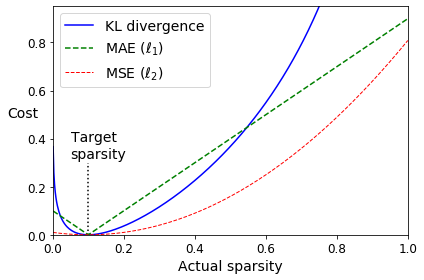

In [44]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [45]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [46]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2651 - rounded_accuracy: 0.8700 - val_loss: 0.2437 - val_rounded_accuracy: 0.8778
Epoch 2/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.2274 - rounded_accuracy: 0.8896 - val_loss: 0.2103 - val_rounded_accuracy: 0.9025
Epoch 3/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.1954 - rounded_accuracy: 0.9106 - val_loss: 0.1859 - val_rounded_accuracy: 0.9181
Epoch 4/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.1764 - rounded_accuracy: 0.9226 - val_loss: 0.1713 - val_rounded_accuracy: 0.9276
Epoch 5/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.1622 - rounded_accuracy: 0.9317 - val_loss: 0.1590 - val_rounded_accuracy: 0.9356
Epoch 6/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.1516 - rounded_accuracy: 0.9379 - val

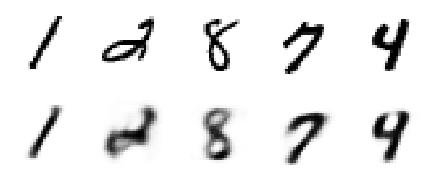

In [47]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


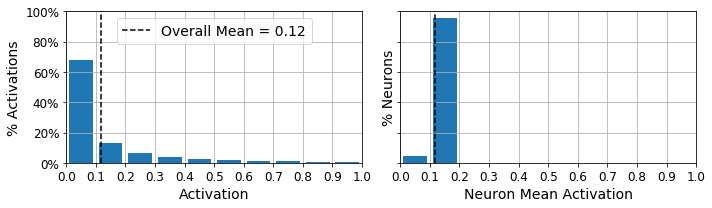

In [48]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# Variational Autoencoder

In [49]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [50]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 52us/sample - loss: 0.2234 - rounded_accuracy: 0.9055 - val_loss: 0.1854 - val_rounded_accuracy: 0.9281
Epoch 2/25
55000/55000 [==============================] - 2s 39us/sample - loss: 0.1774 - rounded_accuracy: 0.9320 - val_loss: 0.1697 - val_rounded_accuracy: 0.9367
Epoch 3/25
55000/55000 [==============================] - 2s 39us/sample - loss: 0.1663 - rounded_accuracy: 0.9386 - val_loss: 0.1636 - val_rounded_accuracy: 0.9400
Epoch 4/25
55000/55000 [==============================] - 2s 39us/sample - loss: 0.1608 - rounded_accuracy: 0.9421 - val_loss: 0.1612 - val_rounded_accuracy: 0.9417
Epoch 5/25
55000/55000 [==============================] - 2s 39us/sample - loss: 0.1572 - rounded_accuracy: 0.9443 - val_loss: 0.1585 - val_rounded_accuracy: 0.9443
Epoch 6/25
55000/55000 [==============================] - 2s 39us/sample - loss: 0.1548 - rounded_accuracy: 0.9459 - val_loss:

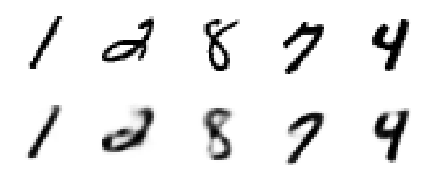

In [51]:
show_reconstructions(variational_ae)
plt.show()

## Generate MNIST Images

In [52]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

Saving figure vae_generated_images_plot


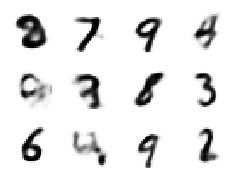

In [53]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Now let's perform semantic interpolation between these images:

Saving figure semantic_interpolation_plot


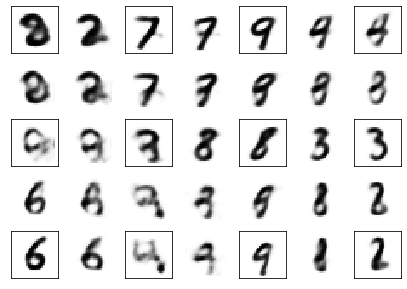

In [54]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# Generative Adversarial Networks

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [56]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [57]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [58]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


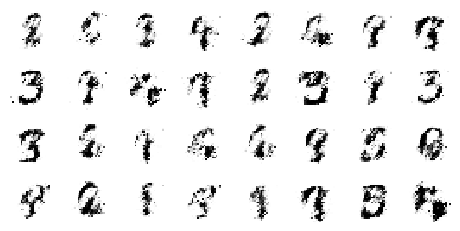

In [59]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Saving figure gan_generated_images_plot


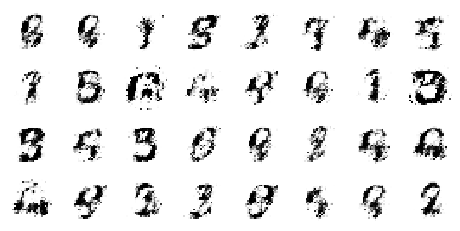

In [60]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

Epoch 1/50


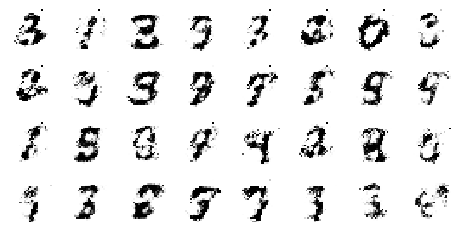

Epoch 2/50


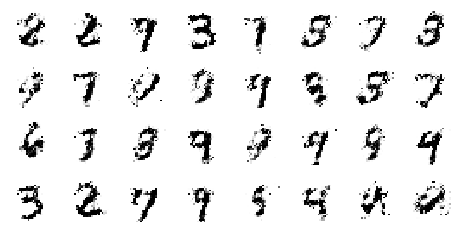

Epoch 3/50


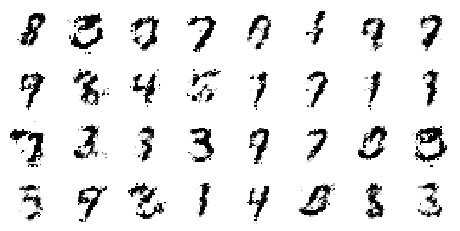

Epoch 4/50


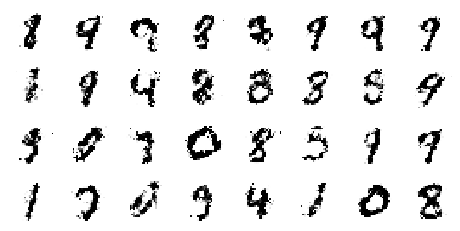

Epoch 5/50


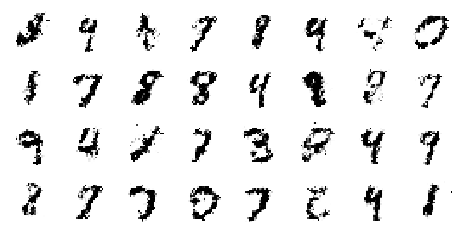

Epoch 6/50


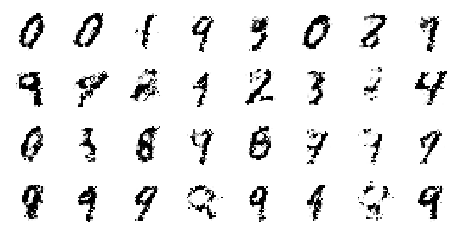

Epoch 7/50


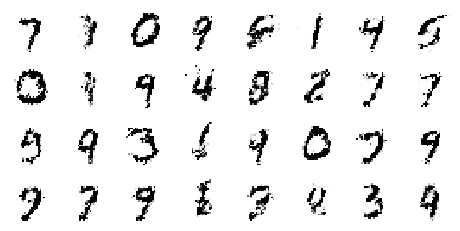

Epoch 8/50


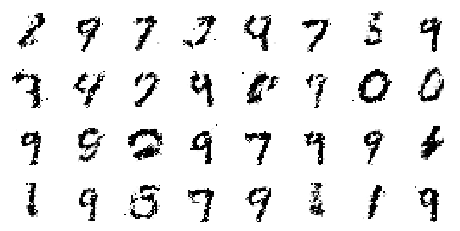

Epoch 9/50


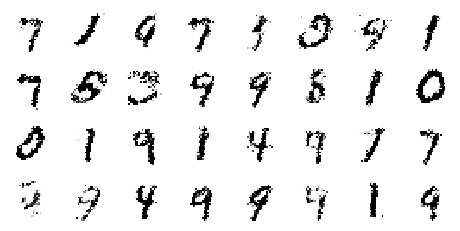

Epoch 10/50


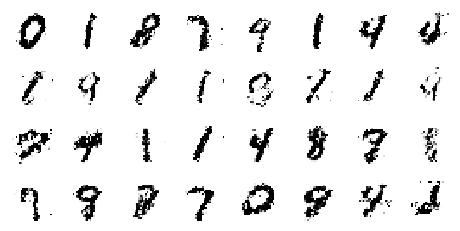

Epoch 11/50


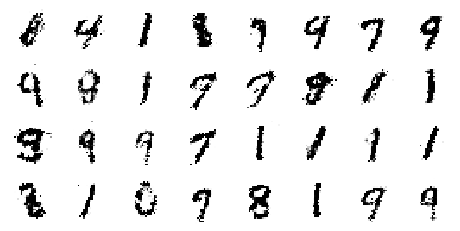

Epoch 12/50


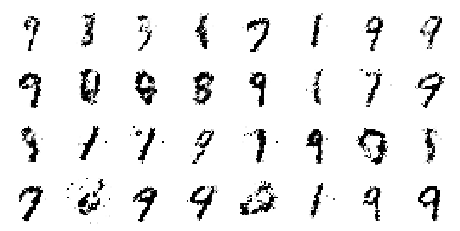

Epoch 13/50


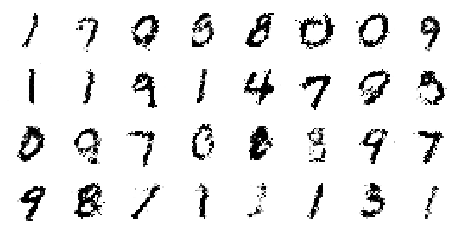

Epoch 14/50


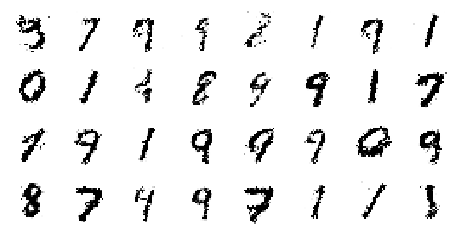

Epoch 15/50


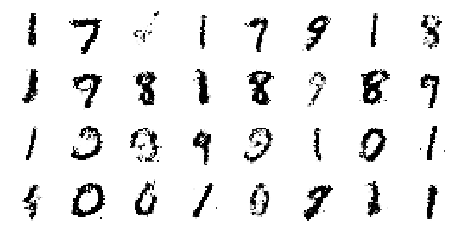

Epoch 16/50


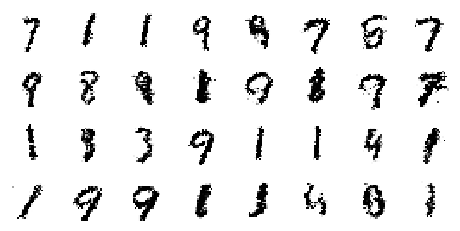

Epoch 17/50


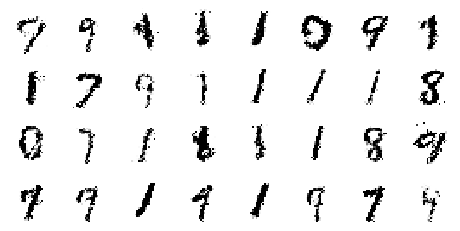

Epoch 18/50


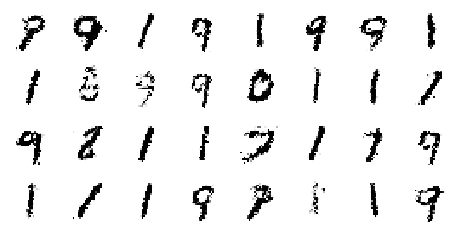

Epoch 19/50


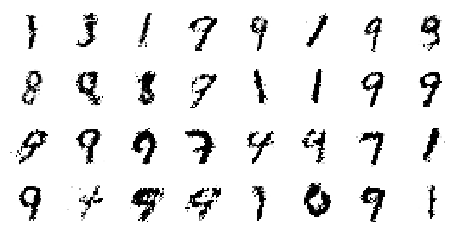

Epoch 20/50


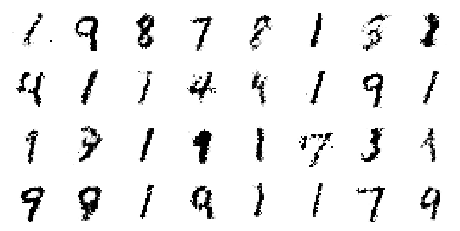

Epoch 21/50


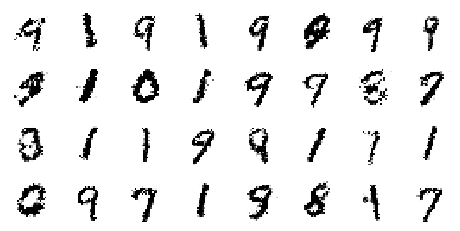

Epoch 22/50


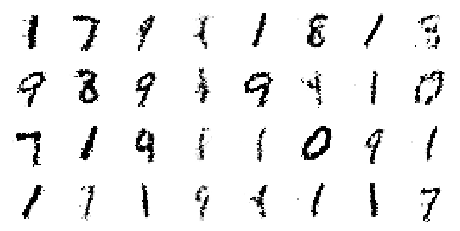

Epoch 23/50


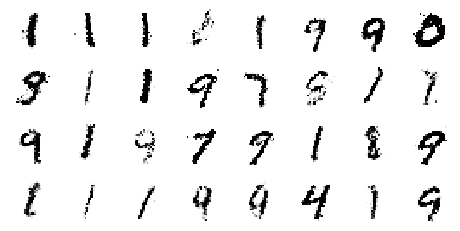

Epoch 24/50


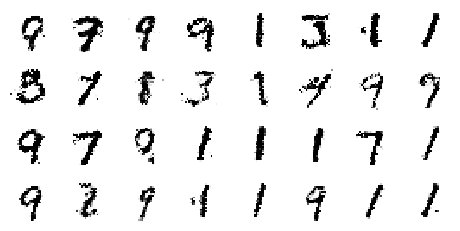

Epoch 25/50


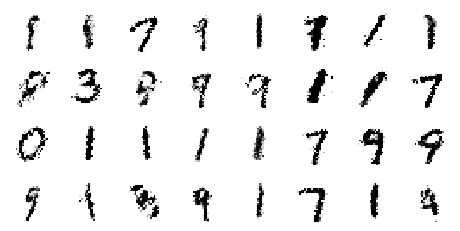

Epoch 26/50


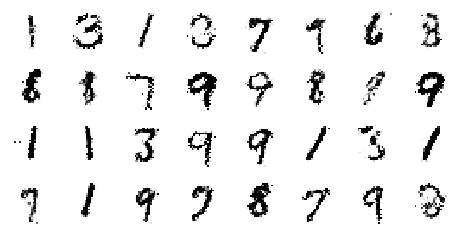

Epoch 27/50


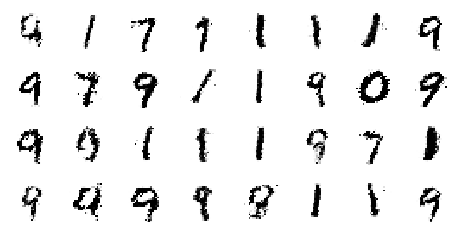

Epoch 28/50


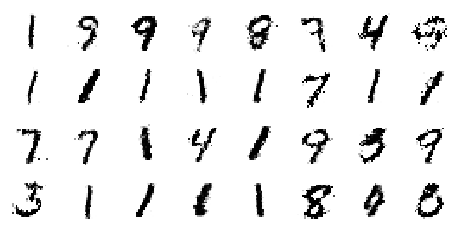

Epoch 29/50


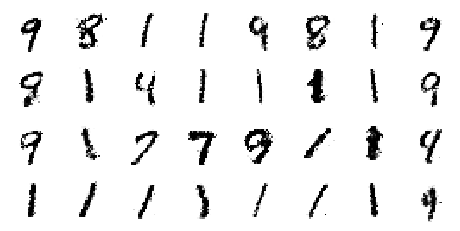

Epoch 30/50


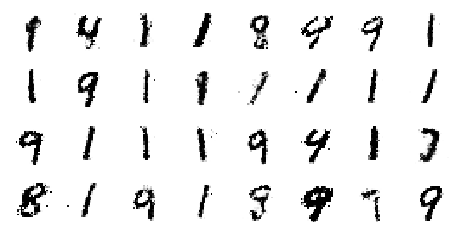

Epoch 31/50


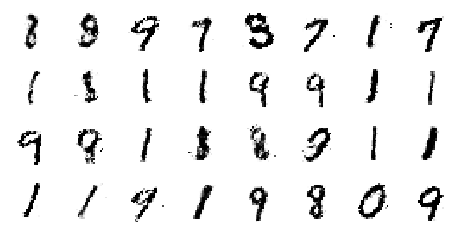

Epoch 32/50


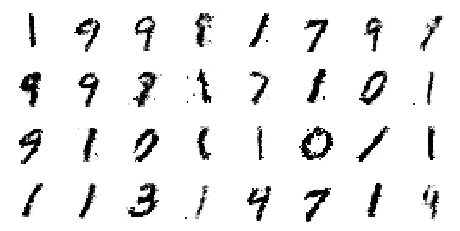

Epoch 33/50


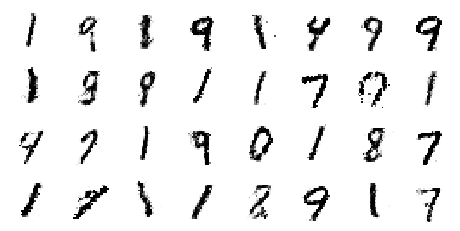

Epoch 34/50


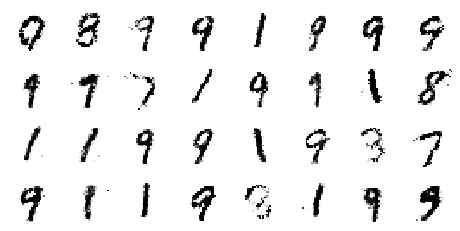

Epoch 35/50


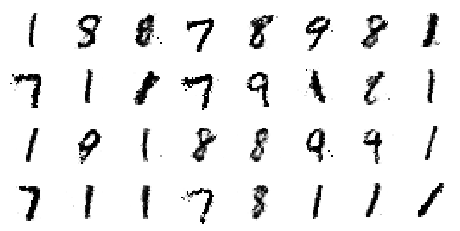

Epoch 36/50


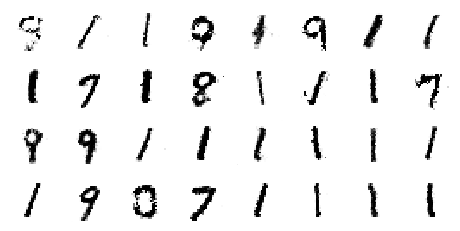

Epoch 37/50


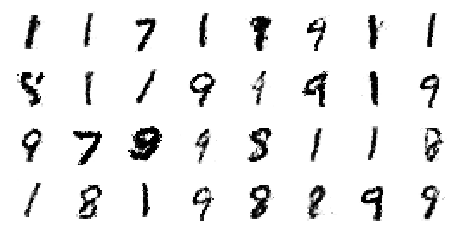

Epoch 38/50


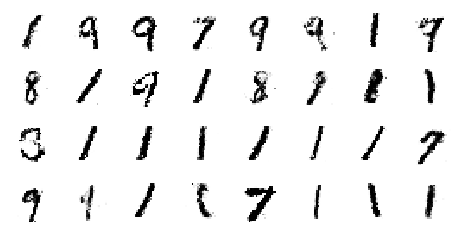

Epoch 39/50


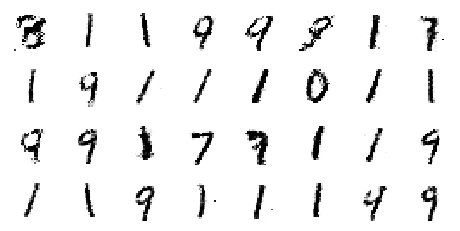

Epoch 40/50


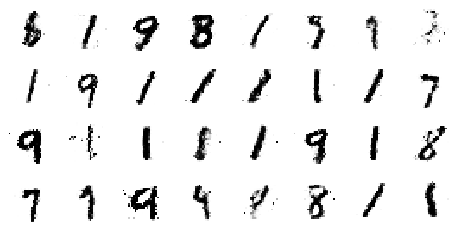

Epoch 41/50


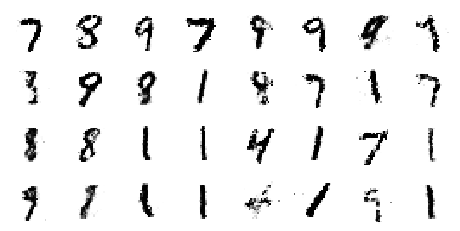

Epoch 42/50


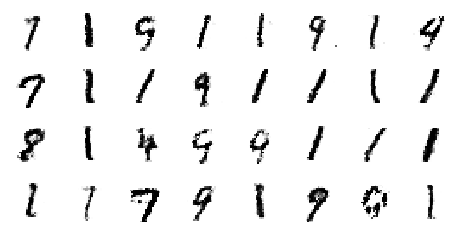

Epoch 43/50


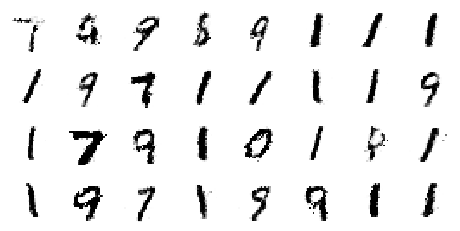

Epoch 44/50


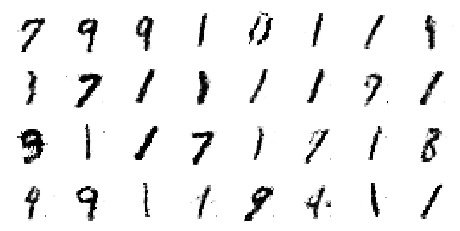

Epoch 45/50


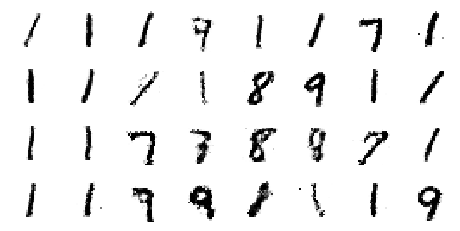

Epoch 46/50


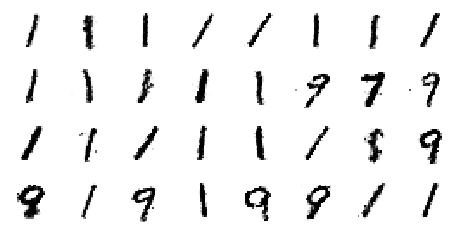

Epoch 47/50


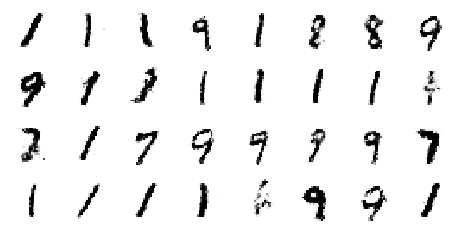

Epoch 48/50


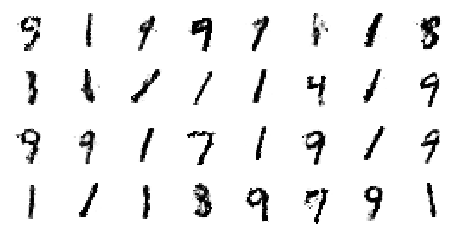

Epoch 49/50


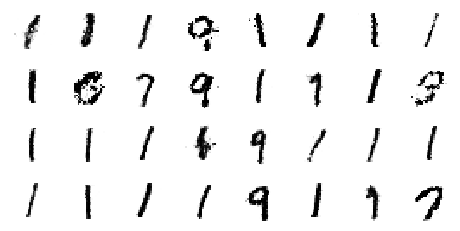

Epoch 50/50


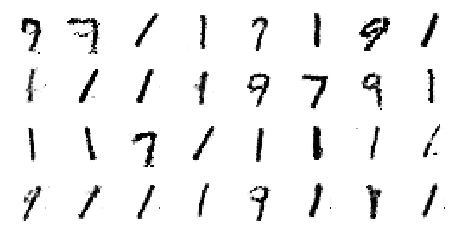

In [61]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep Convolutional GAN

In [62]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [63]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [64]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [65]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


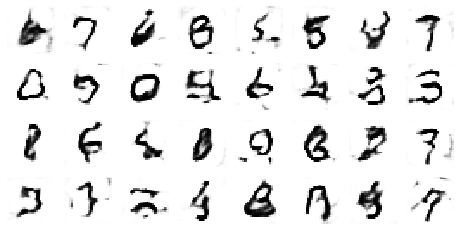

Epoch 2/50


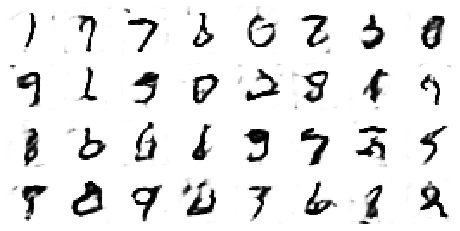

Epoch 3/50


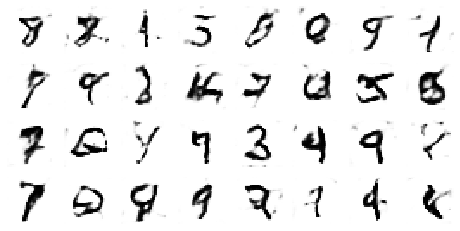

Epoch 4/50


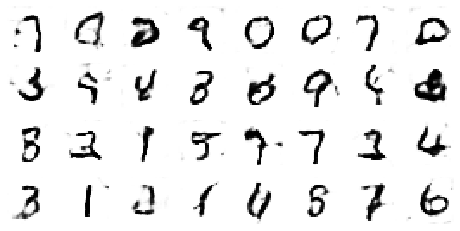

Epoch 5/50


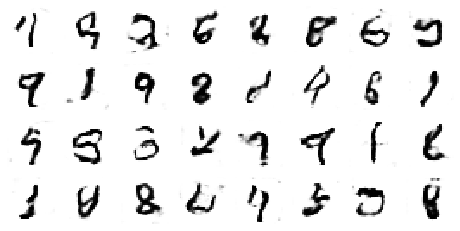

Epoch 6/50


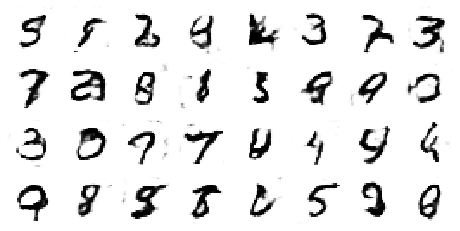

Epoch 7/50


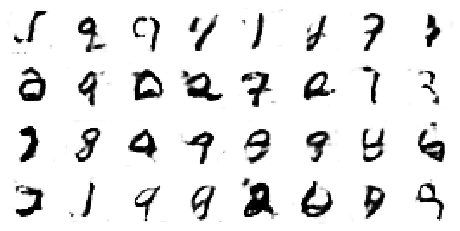

Epoch 8/50


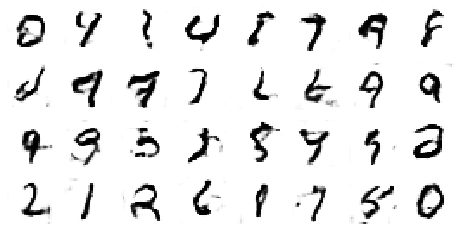

Epoch 9/50


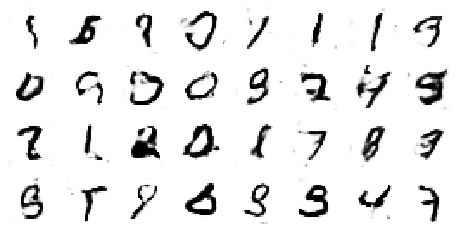

Epoch 10/50


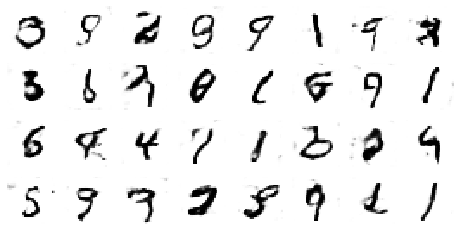

Epoch 11/50


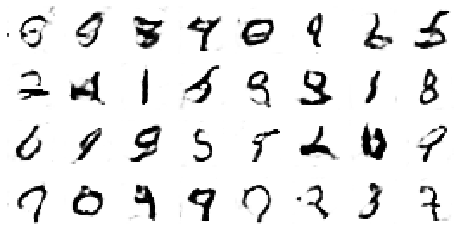

Epoch 12/50


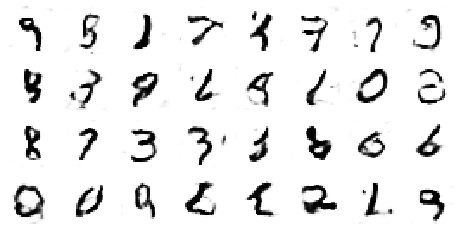

Epoch 13/50


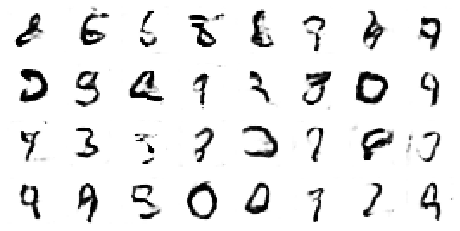

Epoch 14/50


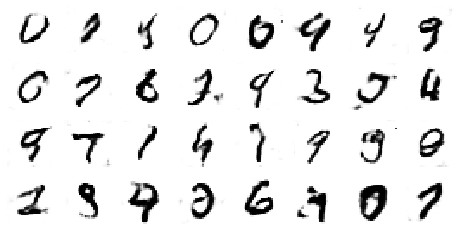

Epoch 15/50


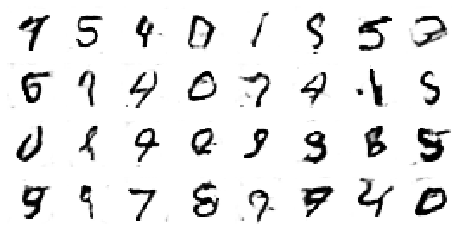

Epoch 16/50


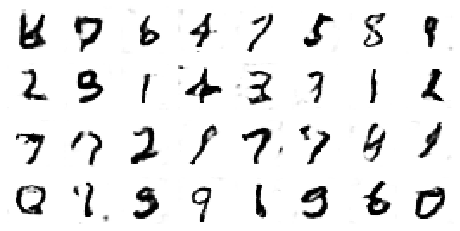

Epoch 17/50


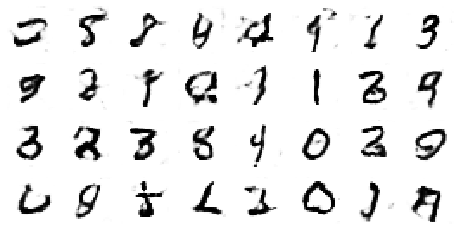

Epoch 18/50


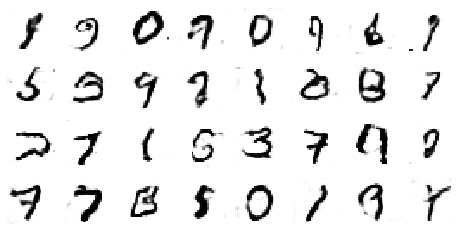

Epoch 19/50


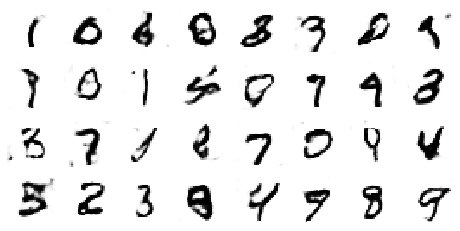

Epoch 20/50


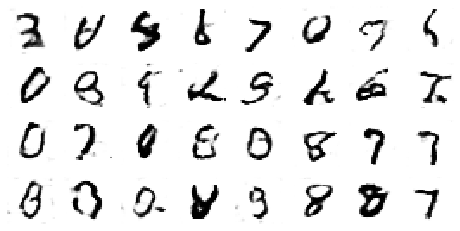

Epoch 21/50


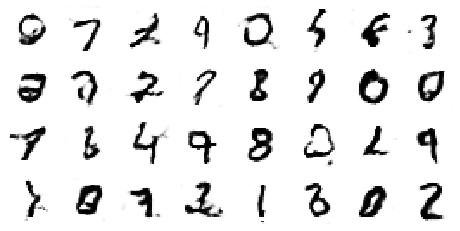

Epoch 22/50


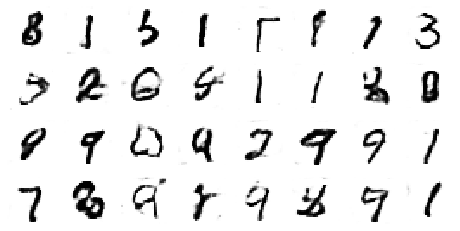

Epoch 23/50


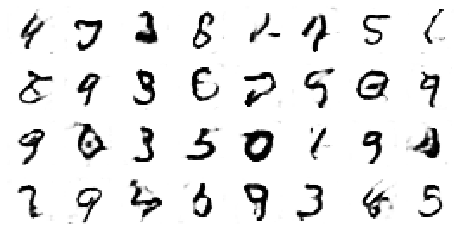

Epoch 24/50


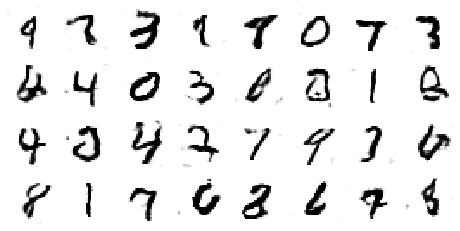

Epoch 25/50


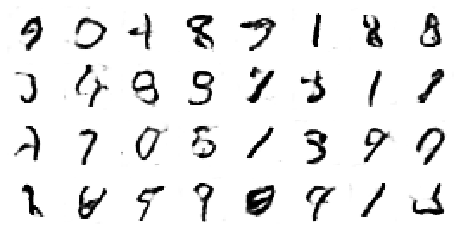

Epoch 26/50


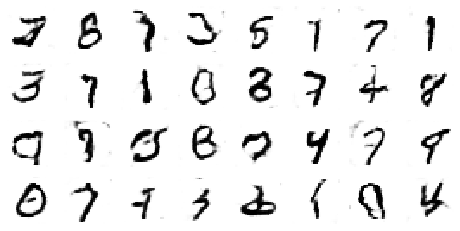

Epoch 27/50


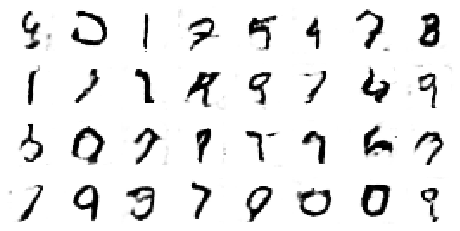

Epoch 28/50


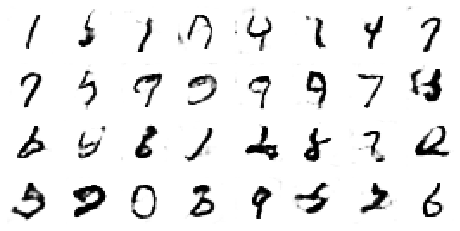

Epoch 29/50


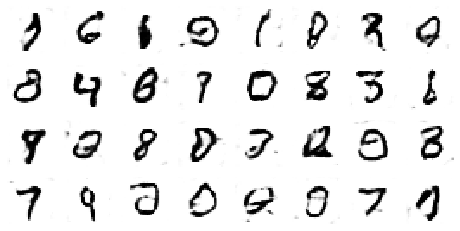

Epoch 30/50


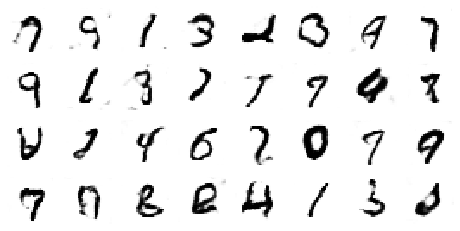

Epoch 31/50


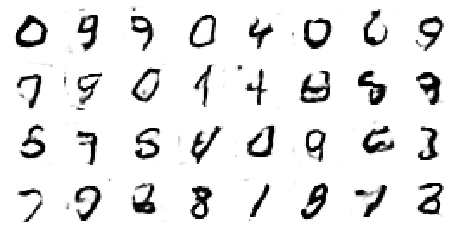

Epoch 32/50


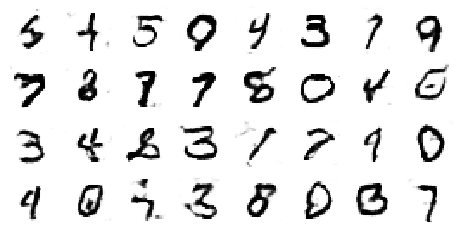

Epoch 33/50


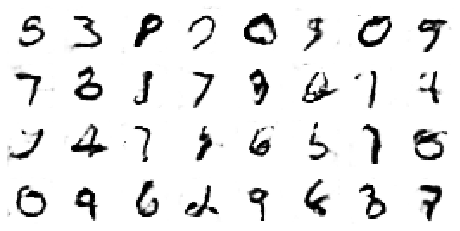

Epoch 34/50


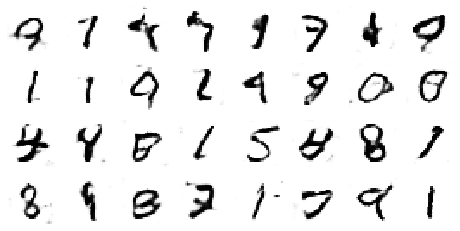

Epoch 35/50


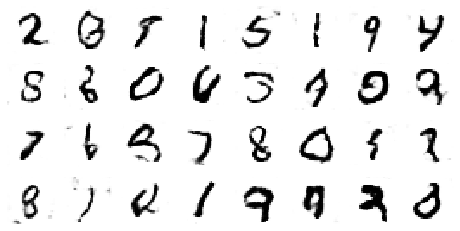

Epoch 36/50


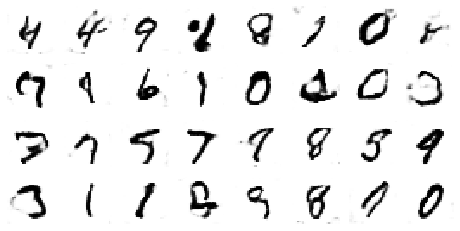

Epoch 37/50


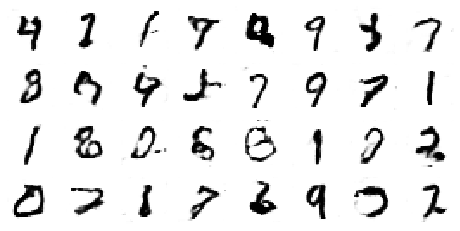

Epoch 38/50


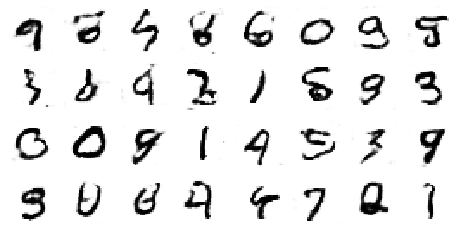

Epoch 39/50


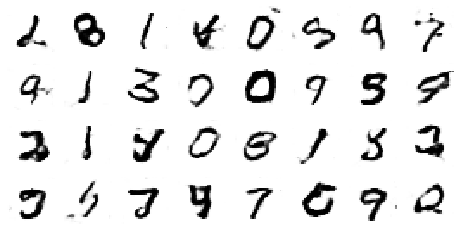

Epoch 40/50


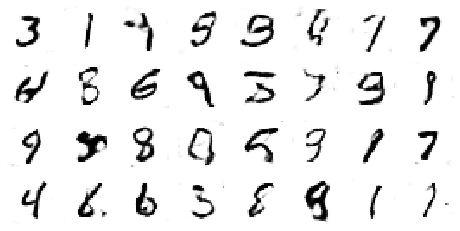

Epoch 41/50


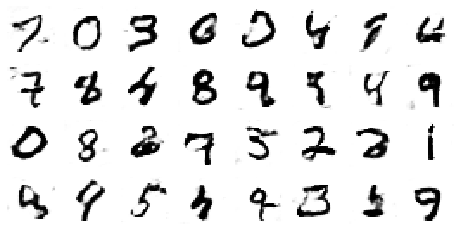

Epoch 42/50


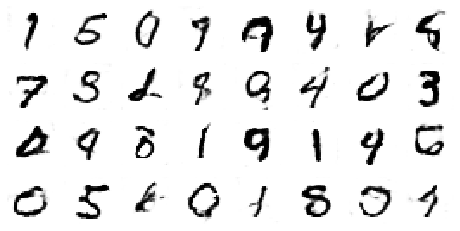

Epoch 43/50


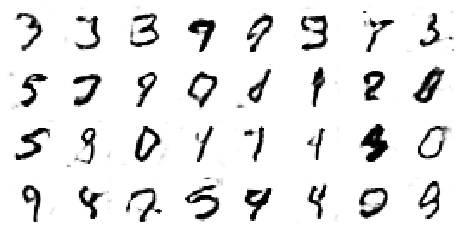

Epoch 44/50


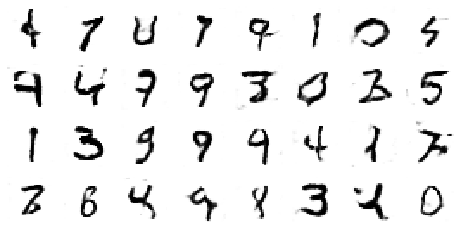

Epoch 45/50


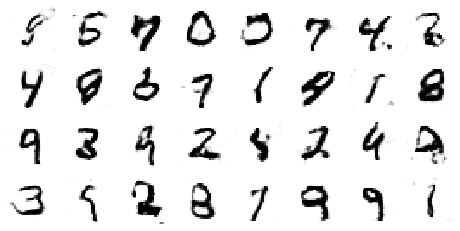

Epoch 46/50


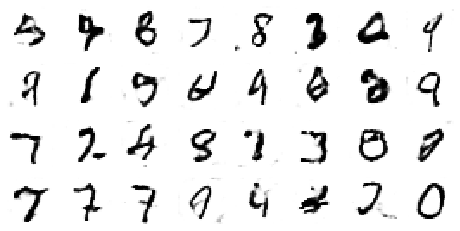

Epoch 47/50


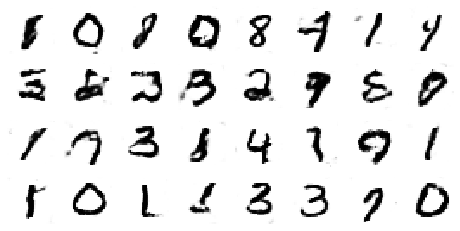

Epoch 48/50


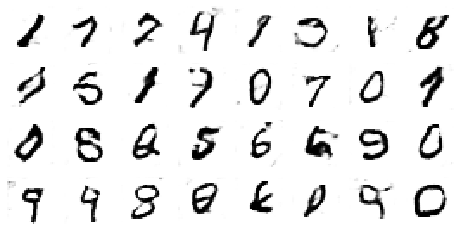

Epoch 49/50


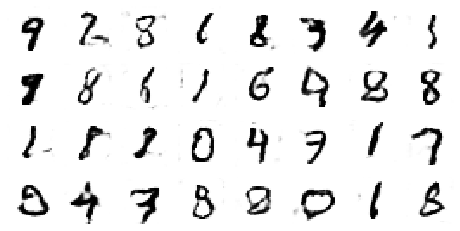

Epoch 50/50


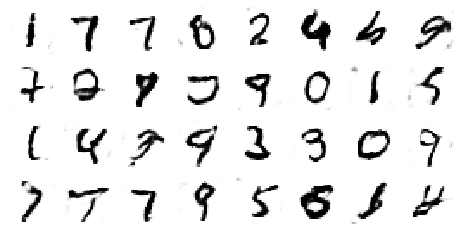

In [66]:
train_gan(gan, dataset, batch_size, codings_size)

Saving figure dcgan_generated_images_plot


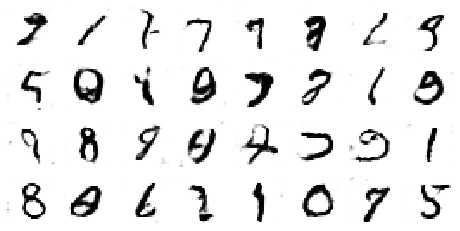

In [67]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

# Exercise Solutions

## Unsupervised pretraining

Let's create a small neural network for MNIST classification:

In [68]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_small = X_train[:500]
y_train_small = y_train[:500]

classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.02),
                   metrics=["accuracy"])
history = classifier.fit(X_train_small, y_train_small, epochs=20, validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 1s 1ms/sample - loss: 2.2661 - accuracy: 0.1820 - val_loss: 2.1609 - val_accuracy: 0.3384
Epoch 2/20
500/500 [==============================] - 0s 643us/sample - loss: 2.0607 - accuracy: 0.4480 - val_loss: 1.9682 - val_accuracy: 0.4926
Epoch 3/20
500/500 [==============================] - 0s 696us/sample - loss: 1.7938 - accuracy: 0.6180 - val_loss: 1.7036 - val_accuracy: 0.6414
Epoch 4/20
500/500 [==============================] - 0s 663us/sample - loss: 1.4322 - accuracy: 0.7180 - val_loss: 1.3625 - val_accuracy: 0.6368
Epoch 5/20
500/500 [==============================] - 0s 694us/sample - loss: 1.0625 - accuracy: 0.7860 - val_loss: 1.0839 - val_accuracy: 0.7018
Epoch 6/20
500/500 [==============================] - 0s 677us/sample - loss: 0.8699 - accuracy: 0.7900 - val_loss: 0.9446 - val_accuracy: 0.7104
Epoch 7/20
500/500 [==============================] - 0s 695us/sample - loss: 0

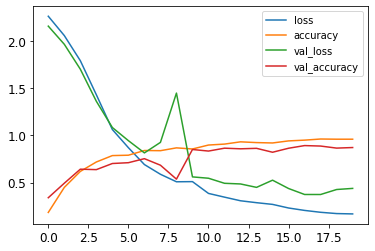

In [69]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [70]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder_clone = keras.models.clone_model(conv_encoder)

pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])

In [71]:
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/30
500/500 [==============================] - 1s 1ms/sample - loss: 2.3324 - accuracy: 0.1080 - val_loss: 2.2753 - val_accuracy: 0.1170
Epoch 2/30
500/500 [==============================] - 0s 677us/sample - loss: 2.2719 - accuracy: 0.1400 - val_loss: 2.2412 - val_accuracy: 0.2134
Epoch 3/30
500/500 [==============================] - 0s 831us/sample - loss: 2.2272 - accuracy: 0.2400 - val_loss: 2.2076 - val_accuracy: 0.2866
Epoch 4/30
500/500 [==============================] - 0s 665us/sample - loss: 2.1853 - accuracy: 0.3520 - val_loss: 2.1758 - val_accuracy: 0.3280
Epoch 5/30
500/500 [==============================] - 0s 633us/sample - loss: 2.1443 - accuracy: 0.3940 - val_loss: 2.1430 - val_accuracy: 0.3720
Epoch 6/30
500/500 [==============================] - 0s 675us/sample - loss: 2.1082 - accuracy: 0.4080 - val_loss: 2.1134 - val_accuracy: 0.4170
Epoch 7/30
500/500 [==============================] - 0s 632us/sample - loss: 2

In [72]:
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20,
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 1s 1ms/sample - loss: 1.0470 - accuracy: 0.7800 - val_loss: 0.9621 - val_accuracy: 0.7544
Epoch 2/20
500/500 [==============================] - 0s 710us/sample - loss: 0.7483 - accuracy: 0.8380 - val_loss: 0.8481 - val_accuracy: 0.7422
Epoch 3/20
500/500 [==============================] - 0s 692us/sample - loss: 0.6288 - accuracy: 0.8220 - val_loss: 0.8892 - val_accuracy: 0.7382
Epoch 4/20
500/500 [==============================] - 0s 707us/sample - loss: 0.5719 - accuracy: 0.8540 - val_loss: 0.6296 - val_accuracy: 0.8234
Epoch 5/20
500/500 [==============================] - 0s 695us/sample - loss: 0.4640 - accuracy: 0.8700 - val_loss: 0.5998 - val_accuracy: 0.8228
Epoch 6/20
500/500 [==============================] - 0s 708us/sample - loss: 0.4358 - accuracy: 0.8680 - val_loss: 0.5466 - val_accuracy: 0.8414
Epoch 7/20
500/500 [==============================] - 0s 695us/sample - loss: 0

## Hashing Using a Binary Autoencoder

In [73]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 89us/sample - loss: 0.2803 - rounded_accuracy: 0.8640 - val_loss: 0.2634 - val_rounded_accuracy: 0.8694
Epoch 2/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.2638 - rounded_accuracy: 0.8687 - val_loss: 0.2616 - val_rounded_accuracy: 0.8697
Epoch 3/10
55000/55000 [==============================] - 4s 81us/sample - loss: 0.2634 - rounded_accuracy: 0.8687 - val_loss: 0.2591 - val_rounded_accuracy: 0.8697
Epoch 4/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.2630 - rounded_accuracy: 0.8689 - val_loss: 0.2564 - val_rounded_accuracy: 0.8712
Epoch 5/10
55000/55000 [==============================] - 5s 83us/sample - loss: 0.2623 - rounded_accuracy: 0.8691 - val_loss: 0.2529 - val_rounded_accuracy: 0.8723
Epoch 6/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2607 - rounded_accuracy: 0.8697 - val_loss:

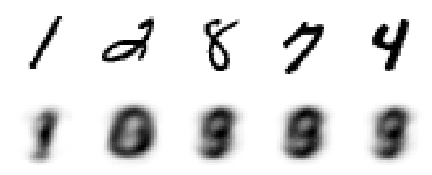

In [74]:
show_reconstructions(hashing_ae)
plt.show()

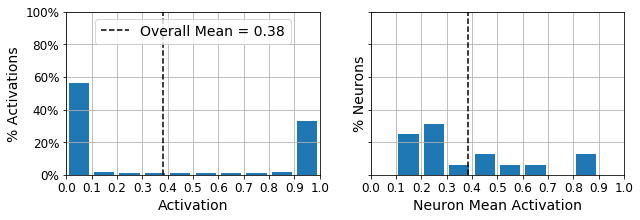

In [75]:
plot_activations_histogram(hashing_encoder)
plt.show()

In [76]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

1011111111011110
0100000000100001
1100100000001011
1100100000100011
1100100000001011
...


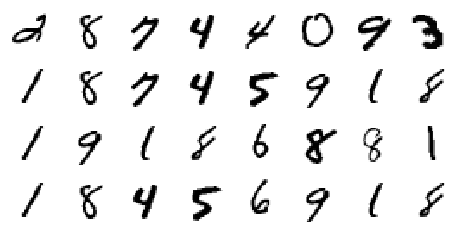

In [77]:
n_bits = 4
n_images = 8
plt.figure(figsize=(n_images, n_bits))
for bit_index in range(n_bits):
    in_bucket = (hashes & 2**bit_index != 0)
    for index, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")